In [2]:

import os
import pandas as pd
import time
import glob
from IPython.display import clear_output
from pyspark.sql import SparkSession
import pyspark.sql.functions as sql_f
from pyspark.sql.types import *
from pyspark.sql.functions import to_date, datediff, floor, col, avg, substring, when, length, lpad
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import unix_timestamp

spark = SparkSession.builder.getOrCreate()



In [4]:
#Synthea Batch Generator with Concatenation of csv files

#Synthea Configuration
total_patients = 100
batch_size = 10
state = "Massachusetts"
age_range = "30-85"
base_seed = 12345
output_dir = "./output"

#Initial setup to ensure java is installed as well as the "synthea-with-dependencies.jar" file needed to create the patient records
def setup_environment():
    """Install Java and download Synthea if not already present"""
    if not os.path.exists("/usr/bin/java"):
        print("Installing Java...")
        !sudo apt-get update -qq > /dev/null
        !sudo apt-get install -y openjdk-11-jdk-headless > /dev/null
        clear_output()
        print("Java installed")

    if not os.path.exists("synthea-with-dependencies.jar"):
        print("Downloading Synthea...")
        !wget -q https://github.com/synthetichealth/synthea/releases/download/master-branch-latest/synthea-with-dependencies.jar
        clear_output()
        print("Synthea downloaded")

    os.makedirs(output_dir, exist_ok=True)

#Batch generation of patients to avoid errors due to kernel reconnecting...
def generate_batch(batch_num, patients_in_batch, current_seed):
    """Generate one batch of synthetic patients"""
    try:
        print(f"Batch {batch_num}: Generating {patients_in_batch} patients (seed: {current_seed})")

        !java -jar synthea-with-dependencies.jar \
          -p {patients_in_batch} \
          -s {current_seed} \
          -a "{age_range}" \
          --exporter.baseDirectory "{output_dir}" \
          --exporter.fhir.export=False \
          --exporter.csv.export=True \
          --exporter.csv.folder_per_run=true \
          {state}

        return True
    except Exception as e:
        print(f"Error in batch {batch_num}: {str(e)}")
        return False

#Combining csv files based on their filenames
def concatenate_all_csvs():
    """Combine all generated CSV files by their type"""
    csv_files = glob.glob(f"{output_dir}/**/*.csv", recursive=True)

    if not csv_files:
        print("No CSV files found to concatenate")
        return None

    combined_data = {}

    for filepath in csv_files:
        filename = os.path.basename(filepath)
        file_type = filename.split('.')[0]

        try:
            df = pd.read_csv(filepath)

            if file_type in combined_data:
                combined_data[file_type] = pd.concat([combined_data[file_type], df], ignore_index=True)
            else:
                combined_data[file_type] = df

        except Exception as e:
            print(f"Could not process {filename}: {str(e)}")

    #Saving combined files
    combined_dir = f"{output_dir}/combined"
    os.makedirs(combined_dir, exist_ok=True)

    for file_type, df in combined_data.items():
        output_path = f"{combined_dir}/{file_type}.csv"
        df.to_csv(output_path, index=False)
        print(f"Saved {len(df)} records to {output_path}")

    return combined_data

#Calling functions from above:
if __name__ == "__main__":
    setup_environment()

    start_time = time.time()
    completed = 0
    batch_num = 1

    print(f"Starting generation of {total_patients} patients in batches of {batch_size}...")

    while completed < total_patients:
        current_batch_size = min(batch_size, total_patients - completed)
        current_seed = base_seed + completed

        #Retrying logic (3 attempts per batch)
        success = False
        for attempt in range(3):
            if generate_batch(batch_num, current_batch_size, current_seed):
                success = True
                break
            time.sleep(5)

        if success:
            completed += current_batch_size
            progress = completed / total_patients * 100
            print(f"Progress: {completed}/{total_patients} ({progress:.1f}%)")
            batch_num += 1
        else:
            print(f"Failed batch {batch_num} after 3 attempts")
            break

    #Concatenate results
    print("\nCombining all CSV files...")
    combined_data = concatenate_all_csvs()


    elapsed = (time.time() - start_time) / 60
    print(f"\n{'='*40}")
    print(f"COMPLETED IN {elapsed:.1f} MINUTES")
    print(f"Total patients generated: {completed}/{total_patients}")

    if combined_data:
        print("\nCOMBINED FILES SUMMARY:")
        for file_type, df in combined_data.items():
            print(f"- {file_type}.csv: {len(df)} records")
    else:
        print("\nNo files were combined")




Synthea downloaded
Starting generation of 100 patients in batches of 10...
Batch 1: Generating 10 patients (seed: 12345)
SLF4J: No SLF4J providers were found.
SLF4J: Defaulting to no-operation (NOP) logger implementation
SLF4J: See http://www.slf4j.org/codes.html#noProviders for further details.
Scanned 88 modules and 152 submodules.
Loading submodule modules/allergies/allergy_panel.json
Loading submodule modules/allergies/drug_allergy_incidence.json
Loading submodule modules/allergies/environmental_allergy_incidence.json
Loading submodule modules/allergies/food_allergy_incidence.json
Loading submodule modules/allergies/immunotherapy.json
Loading submodule modules/allergies/outgrow_env_allergies.json
Loading submodule modules/allergies/outgrow_food_allergies.json
Loading submodule modules/allergies/severe_allergic_reaction.json
Loading submodule modules/anemia/anemia_sub.json
Loading submodule modules/breast_cancer/chemotherapy_breast.json
Loading submodule modules/breast_cancer/hormon

In [7]:
path = "/content/output/combined/"

In [8]:
#patient
observations = spark.read.csv(path+"observations.csv", header=True)
patient = spark.read.csv(path+"patients.csv", header=True)

#medical
careplans = spark.read.csv(path+"careplans.csv", header=True)
conditions = spark.read.csv(path+"conditions.csv", header=True)
procedures=spark.read.csv(path+"procedures.csv", header=True)
encounters = spark.read.csv(path+"encounters.csv", header=True)
medications = spark.read.csv(path+"medications.csv", header=True)

#insurance and hospital
payer_transitions=spark.read.csv(path+"payer_transitions.csv", header=True)
payers=spark.read.csv(path+"payers.csv", header=True)
providers=spark.read.csv(path+"providers.csv", header=True)
organizations=spark.read.csv(path+"organizations.csv", header=True)


In [9]:

# renaming columns
patient = (
    patient.withColumnRenamed("Id", "patient_id")
           .withColumnRenamed("MARITAL", "patient_marital")
           .withColumnRenamed("RACE", "patient_race")
           .withColumnRenamed("ETHNICITY", "patient_ethnicity")
           .withColumnRenamed("GENDER", "patient_gender")
           .withColumnRenamed("ZIP", "patient_zip")
)

encounters = (
    encounters.withColumnRenamed("PATIENT", "patient_id")
              .withColumnRenamed("Id", "encounter_id")
              .withColumnRenamed("DESCRIPTION", "encounter_description")
              .withColumnRenamed("CODE", "encounter_code")
              .withColumnRenamed("START", "encounter_start")
              .withColumn("encounter_start", to_date("encounter_start"))
              .withColumnRenamed("STOP", "encounter_stop")
              .withColumn("encounter_stop", to_date("encounter_stop"))
              .withColumn("PATIENT COST", col("TOTAL_CLAIM_COST") - col("PAYER_COVERAGE"))
              .withColumnRenamed("PAYER", "payer_id")
              .withColumnRenamed("ORGANIZATION", "organization_id")
              .withColumnRenamed("PROVIDER", "provider_id")
)

careplans = (
    careplans.withColumnRenamed("PATIENT", "patient_id")
             .withColumnRenamed("Id", "careplan_id")
             .withColumnRenamed("ENCOUNTER", "encounter_id")
             .withColumnRenamed("DESCRIPTION", "careplan_descriptions")
             .withColumnRenamed("CODE", "careplan_code")
)

procedures = (
    procedures.withColumnRenamed("PATIENT", "patient_id")
              .withColumnRenamed("ENCOUNTER", "encounter_id")
              .withColumnRenamed("DESCRIPTION", "procedure_descriptions")
              .withColumnRenamed("CODE", "procedure_code")
              .withColumnRenamed("DATE", "procedure_date")
              .withColumnRenamed("BASE_COST", "procedure_cost")
)

conditions = (
    conditions.withColumnRenamed("PATIENT", "patient_id")
              .withColumnRenamed("ENCOUNTER", "encounter_id")
              .withColumnRenamed("DESCRIPTION", "condition_description")
              .withColumnRenamed("CODE", "condition_code")
              .withColumnRenamed("START", "condition_start")
              .withColumnRenamed("END", "condition_end")
)

observations = (
    observations.withColumnRenamed("PATIENT", "patient_id")
                .withColumnRenamed("ENCOUNTER", "encounter_id")
                .withColumnRenamed("DATE", "observation_date")
                .withColumn("observation_date", to_date("observation_date"))
)

medications = (
    medications.withColumnRenamed("START", "medication_start")
               .withColumn("medication_start", to_date("medication_start"))
               .withColumnRenamed("STOP", "medication_stop")
               .withColumn("medication_stop", to_date("medication_stop"))
               .withColumnRenamed("PATIENT", "patient_id")
               .withColumnRenamed("PAYER", "payer_id")
               .withColumnRenamed("ENCOUNTER", "encounter_id")
               .withColumnRenamed("CODE", "medication_code")
               .withColumnRenamed("DESCRIPTION", "medication_description")
)

payer_transitions = (
    payer_transitions.withColumnRenamed("PATIENT", "patient_id")
                     .withColumnRenamed("PAYER", "payer_id")
)

payers = (
    payers.withColumnRenamed("Id", "payer_id")
          .withColumnRenamed("NAME", "payer_name")
          .withColumnRenamed("OWNERSHIP", "payer_ownership")
)

providers = (
    providers.withColumnRenamed("Id", "provider_id")
             .withColumnRenamed("SPECIALITY", "provider_specialty")
)

organizations = (
    organizations.withColumnRenamed("Id", "organization_id")
                 .withColumnRenamed("NAME", "organization_name")
                 .withColumnRenamed("ZIP", "organization_zip")
                 .withColumn("organization_zip", substring(col("organization_zip").cast("string"), 1, 5))
)


In [10]:
encounters = (
    encounters
    .join(payers.select("payer_id", "payer_name", "payer_ownership"), on="payer_id", how="left")
    .join(organizations.select("organization_id", "organization_name", "organization_zip"), on="organization_id", how="left")
    .join(providers.select("provider_id", "provider_specialty"), on="provider_id", how="left")
    .join(procedures.select("encounter_id", "procedure_descriptions", "procedure_code"), on="encounter_id", how="left")
    .join(patient.select("patient_id", "BIRTHDATE", "patient_marital", "patient_race", "patient_ethnicity", "patient_gender", "patient_zip"), on="patient_id", how="left")
    .withColumn("age_at_encounter", floor(datediff(col("encounter_start"), col("BIRTHDATE")) / 365.25))
)


In [11]:
encounters.show(1)

+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+--------------+--------------+--------------+---------------------+-------------------+----------------+--------------+----------+-----------------+------------+----------+---------------+--------------------+----------------+------------------+----------------------+--------------+----------+---------------+------------+-----------------+--------------+-----------+----------------+
|          patient_id|        encounter_id|         provider_id|     organization_id|            payer_id|encounter_start|encounter_stop|ENCOUNTERCLASS|encounter_code|encounter_description|BASE_ENCOUNTER_COST|TOTAL_CLAIM_COST|PAYER_COVERAGE|REASONCODE|REASONDESCRIPTION|PATIENT COST|payer_name|payer_ownership|   organization_name|organization_zip|provider_specialty|procedure_descriptions|procedure_code| BIRTHDATE|patient_marital|patient_race|patient_ethnicity|patient_gender|patient_zip|ag

In [12]:
payer_summary = (
    encounters
    .select(
        "payer_ownership",
        col("PAYER_COVERAGE").cast("double"),
        col("TOTAL_CLAIM_COST").cast("double")
    )
    .groupBy("payer_ownership")
    .agg(
        avg("PAYER_COVERAGE").alias("avg_payer_coverage"),
        avg("TOTAL_CLAIM_COST").alias("avg_total_claim")
    )
)

payer_summary.show()

+---------------+------------------+-----------------+
|payer_ownership|avg_payer_coverage|  avg_total_claim|
+---------------+------------------+-----------------+
|     GOVERNMENT| 4116.267626151121|4709.980976525091|
|   NO_INSURANCE|               0.0| 8450.89465837203|
|        PRIVATE| 3474.295369569464|5371.307062556493|
+---------------+------------------+-----------------+



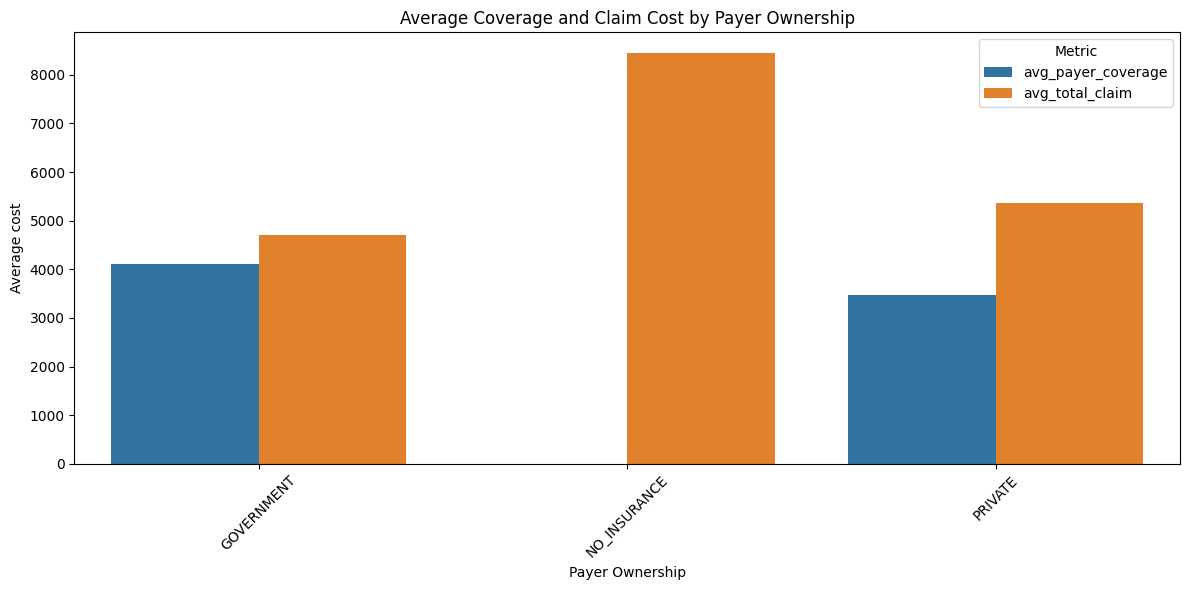

In [20]:
# Convert Spark DataFrame to Pandas
payer_summary_pd = payer_summary.toPandas()

# Reshape the DataFrame to long format for grouped bars
payer_melted = pd.melt(
    payer_summary_pd,
    id_vars="payer_ownership",
    value_vars=["avg_payer_coverage", "avg_total_claim"],
    var_name="Metric",
    value_name="Value"
)

# Plot side-by-side bars (grouped by payer_ownership)
plt.figure(figsize=(12, 6))
sns.barplot(
    data=payer_melted,
    x="payer_ownership",
    y="Value",
    hue="Metric"
)
plt.xlabel("Payer Ownership")
plt.ylabel("Average cost")
plt.title("Average Coverage and Claim Cost by Payer Ownership")
plt.xticks(rotation=45)
plt.legend(title="Metric")
plt.tight_layout()
plt.show()

In [ ]:
#different payers and how much they pay
#total claims
#payer coverage for different encounter class
#prices per zip
#procedure code

In [19]:
encounter_summary = (
    encounters
    .select(
        col("PAYER_COVERAGE").cast("double"),
        col("ENCOUNTERCLASS")
    )
    .groupBy("ENCOUNTERCLASS")
    .agg(
        avg("PAYER_COVERAGE").alias("avg_payer_coverage")
    )
)

encounter_summary.show()

+--------------+------------------+
|ENCOUNTERCLASS|avg_payer_coverage|
+--------------+------------------+
|      wellness|  832.631809862678|
|    outpatient| 919.4247549076395|
|     emergency| 5651.249545669777|
|       virtual| 427.5895652173908|
|     inpatient| 12781.13865945504|
|          home|  696.508912133883|
|    urgentcare|   1170.0321504943|
|       hospice| 8435.877703016215|
|    ambulatory|3561.6267605312128|
|           snf|15572.685212355478|
+--------------+------------------+



In [22]:
patient_summary = (
    encounters
    .select(
        col("PATIENT COST").cast("double"),
        col("ENCOUNTERCLASS")
    )
    .groupBy("ENCOUNTERCLASS")
    .agg(
        avg("PATIENT COST").alias("avg_patient_cost")
    )
)

patient_summary.show()

+--------------+------------------+
|ENCOUNTERCLASS|  avg_patient_cost|
+--------------+------------------+
|      wellness| 548.7028103710214|
|    outpatient|441.78624497749166|
|     emergency|2216.7542167534257|
|       virtual|184.06608695652147|
|     inpatient|2890.9169190968987|
|          home|100.12694560669347|
|    urgentcare| 277.7306657252618|
|       hospice| 3637.719582366607|
|    ambulatory| 2495.405061230472|
|           snf|2646.0938996139666|
+--------------+------------------+



In [25]:
encounter_summary = (
    encounters
    .select(
        "ENCOUNTERCLASS",
        col("PAYER_COVERAGE").cast("double"),
        col("TOTAL_CLAIM_COST").cast("double")
    )
    .groupBy("ENCOUNTERCLASS")
    .agg(
        avg("PAYER_COVERAGE").alias("avg_payer_coverage"),
        avg("TOTAL_CLAIM_COST").alias("avg_total_claim")
    )
)

encounter_summary.show()

+--------------+------------------+------------------+
|ENCOUNTERCLASS|avg_payer_coverage|   avg_total_claim|
+--------------+------------------+------------------+
|      wellness|  832.631809862678|1381.3346202340122|
|    outpatient| 919.4247549076395|1361.2109998847834|
|     emergency| 5651.249545669777| 7868.003762422273|
|       virtual| 427.5895652173908|  611.655652173913|
|     inpatient| 12781.13865945504| 15672.05557854963|
|          home|  696.508912133883| 796.6358577405739|
|    urgentcare|   1170.0321504943|1447.7628162193346|
|       hospice| 8435.877703016215|12073.597285384583|
|    ambulatory|3561.6267605312128| 6057.031821741967|
|           snf|15572.685212355478| 18218.77911196847|
+--------------+------------------+------------------+



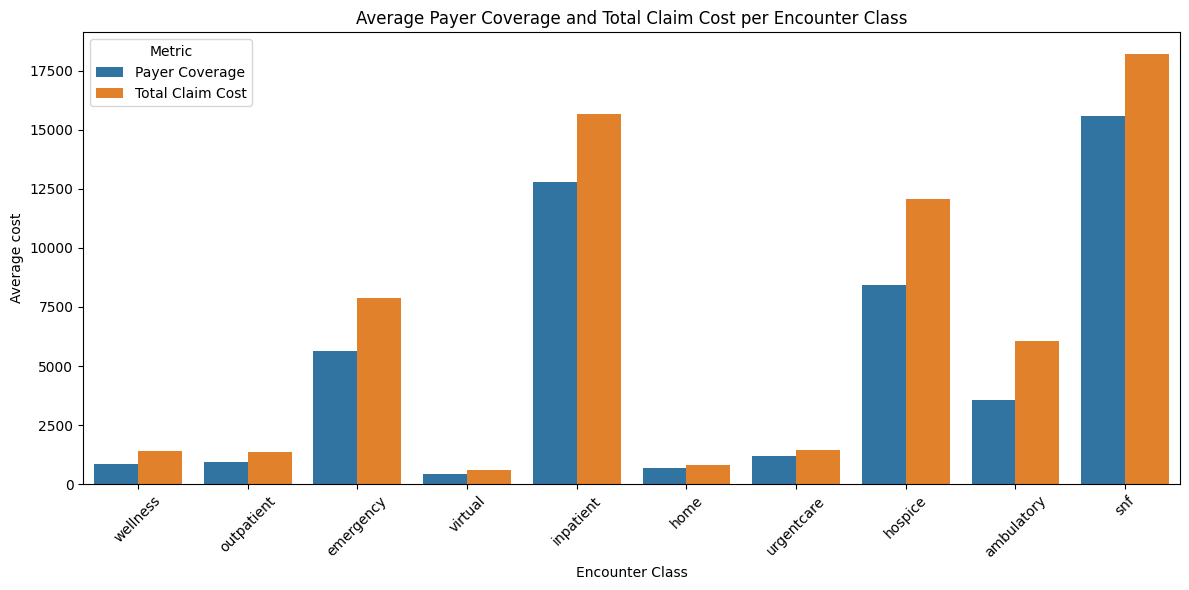

In [47]:
# Convert Spark DataFrame to Pandas
encounter_summary_pd = encounter_summary.toPandas()

# Reshape the DataFrame to long format for grouped bars
encounter_melted = pd.melt(
    encounter_summary_pd ,
    id_vars="ENCOUNTERCLASS",
    value_vars=["avg_payer_coverage", "avg_total_claim"],
    var_name="Metric",
    value_name="Value"
)
encounter_melted["Metric"] = encounter_melted["Metric"].replace({
    "avg_payer_coverage": "Payer Coverage",
    "avg_total_claim": "Total Claim Cost"
})

# Plot side-by-side bars (grouped by payer_ownership)
plt.figure(figsize=(12, 6))
sns.barplot(
    data=encounter_melted,
    x="ENCOUNTERCLASS",
    y="Value",
    hue="Metric"
)
plt.xlabel("Encounter Class")
plt.ylabel("Average cost")
plt.title("Average Payer Coverage and Total Claim Cost per Encounter Class")
plt.xticks(rotation=45)
plt.legend(title="Metric")
plt.tight_layout()
plt.show()

In [34]:
#prices per zip
#organization_zip
zip_summary = (
    encounters
    .select(
        "organization_zip",
        col("PAYER_COVERAGE").cast("double"),
        col("TOTAL_CLAIM_COST").cast("double"),
        "ENCOUNTERCLASS"
    )
    .groupBy("ENCOUNTERCLASS","organization_zip")
    .agg(
        avg("PAYER_COVERAGE").alias("avg_payer_coverage"),
        avg("TOTAL_CLAIM_COST").alias("avg_total_claim")
    )
)

zip_summary.show()


+--------------+----------------+------------------+------------------+
|ENCOUNTERCLASS|organization_zip|avg_payer_coverage|   avg_total_claim|
+--------------+----------------+------------------+------------------+
|       virtual|           18761|               0.0|              75.0|
|           snf|           21281| 2607.020000000001| 5719.119999999996|
|    ambulatory|           23602| 2733.202424242419|  3419.09545454545|
|     emergency|           18804|11512.130000000001|14531.439999999999|
|    outpatient|           20729| 350.1766666666669| 515.3916666666678|
|    ambulatory|           14344| 1982.450072463758|3284.7898550724835|
|    ambulatory|           21802| 3198.846774193503| 3341.674903225732|
|    urgentcare|           18673| 746.9599999999994| 933.7200000000007|
|     inpatient|           12014|2419.2399999999993|2452.5733333333324|
|      wellness|           21131|161.55688311688368|1095.6535064934992|
|    outpatient|           21522|256.93333333333305| 511.5733333

<ipython-input-48-3bf37bf83cae>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-48-3bf37bf83cae>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-48-3bf37bf83cae>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-48-3bf37bf83cae>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


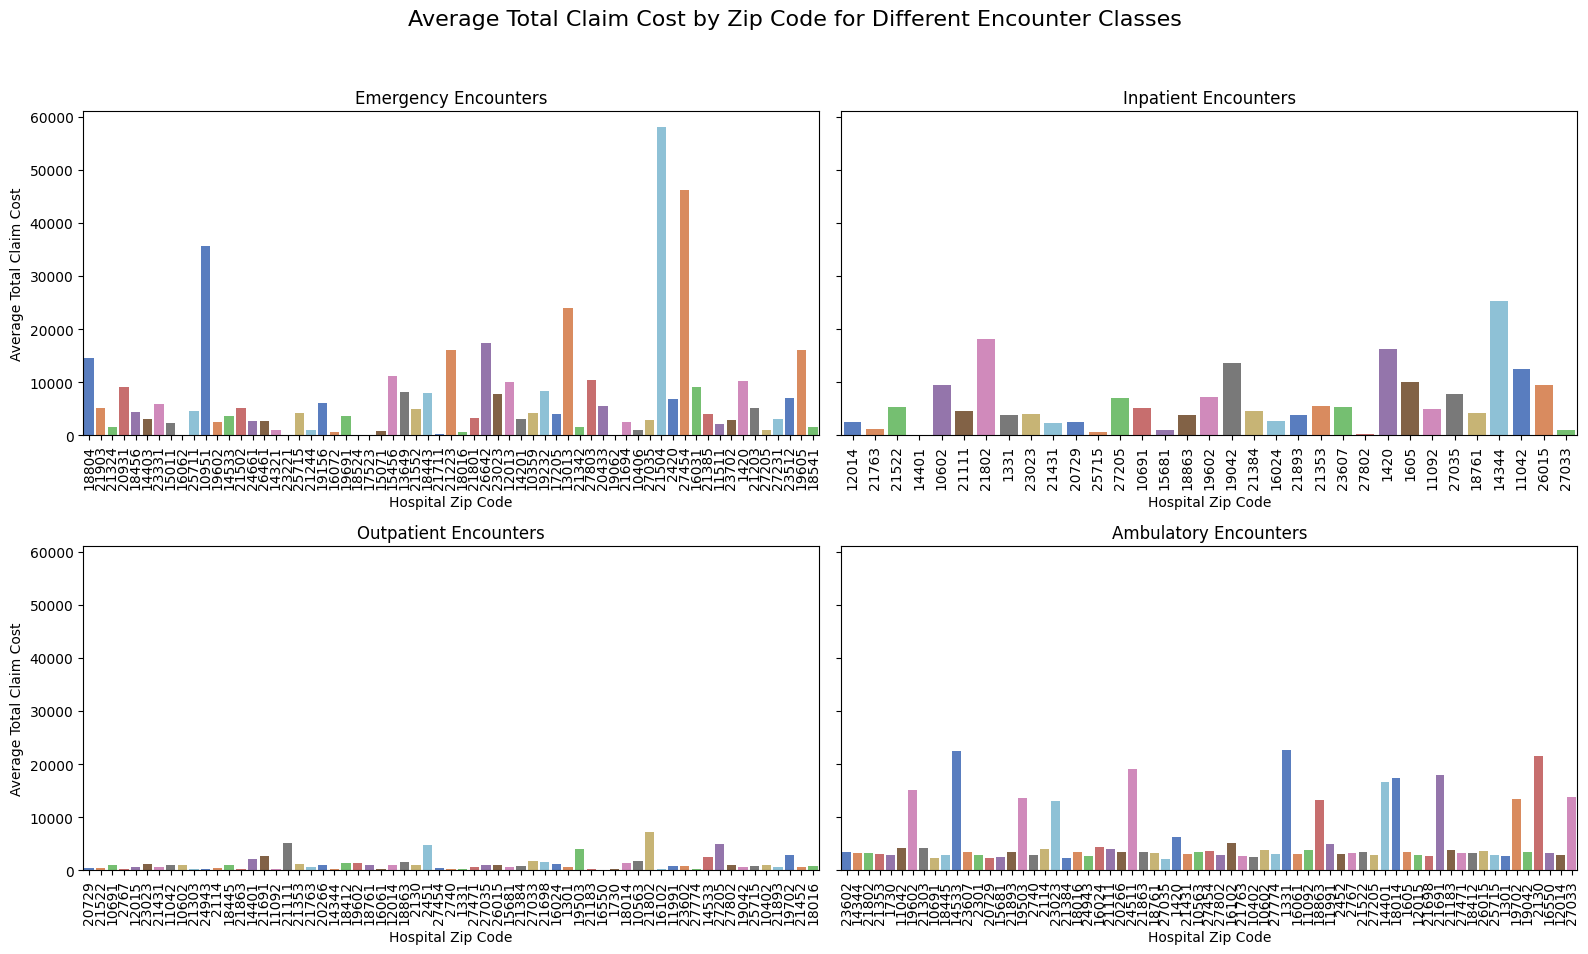

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert to pandas
zip_summary_pd = zip_summary.toPandas()

# Select 4 encounter classes (or change to your preferred ones)
classes = ["emergency", "inpatient", "outpatient", "ambulatory"]
filtered = zip_summary_pd[zip_summary_pd["ENCOUNTERCLASS"].isin(classes)]

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharey=True)

for ax, encounter_class in zip(axes.flatten(), classes):
    class_data = filtered[filtered["ENCOUNTERCLASS"] == encounter_class]
    sns.barplot(
        data=class_data,
        x="organization_zip",
        y="avg_total_claim",
        ax=ax,
        palette="muted"
    )
    ax.set_title(f"{encounter_class.title()} Encounters")
    ax.set_xlabel("Hospital Zip Code")
    ax.set_ylabel("Average Total Claim Cost")
    ax.tick_params(axis='x', rotation=90)

plt.suptitle("Average Total Claim Cost by Zip Code for Different Encounter Classes", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


<ipython-input-54-62fb8499dcf8>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-54-62fb8499dcf8>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


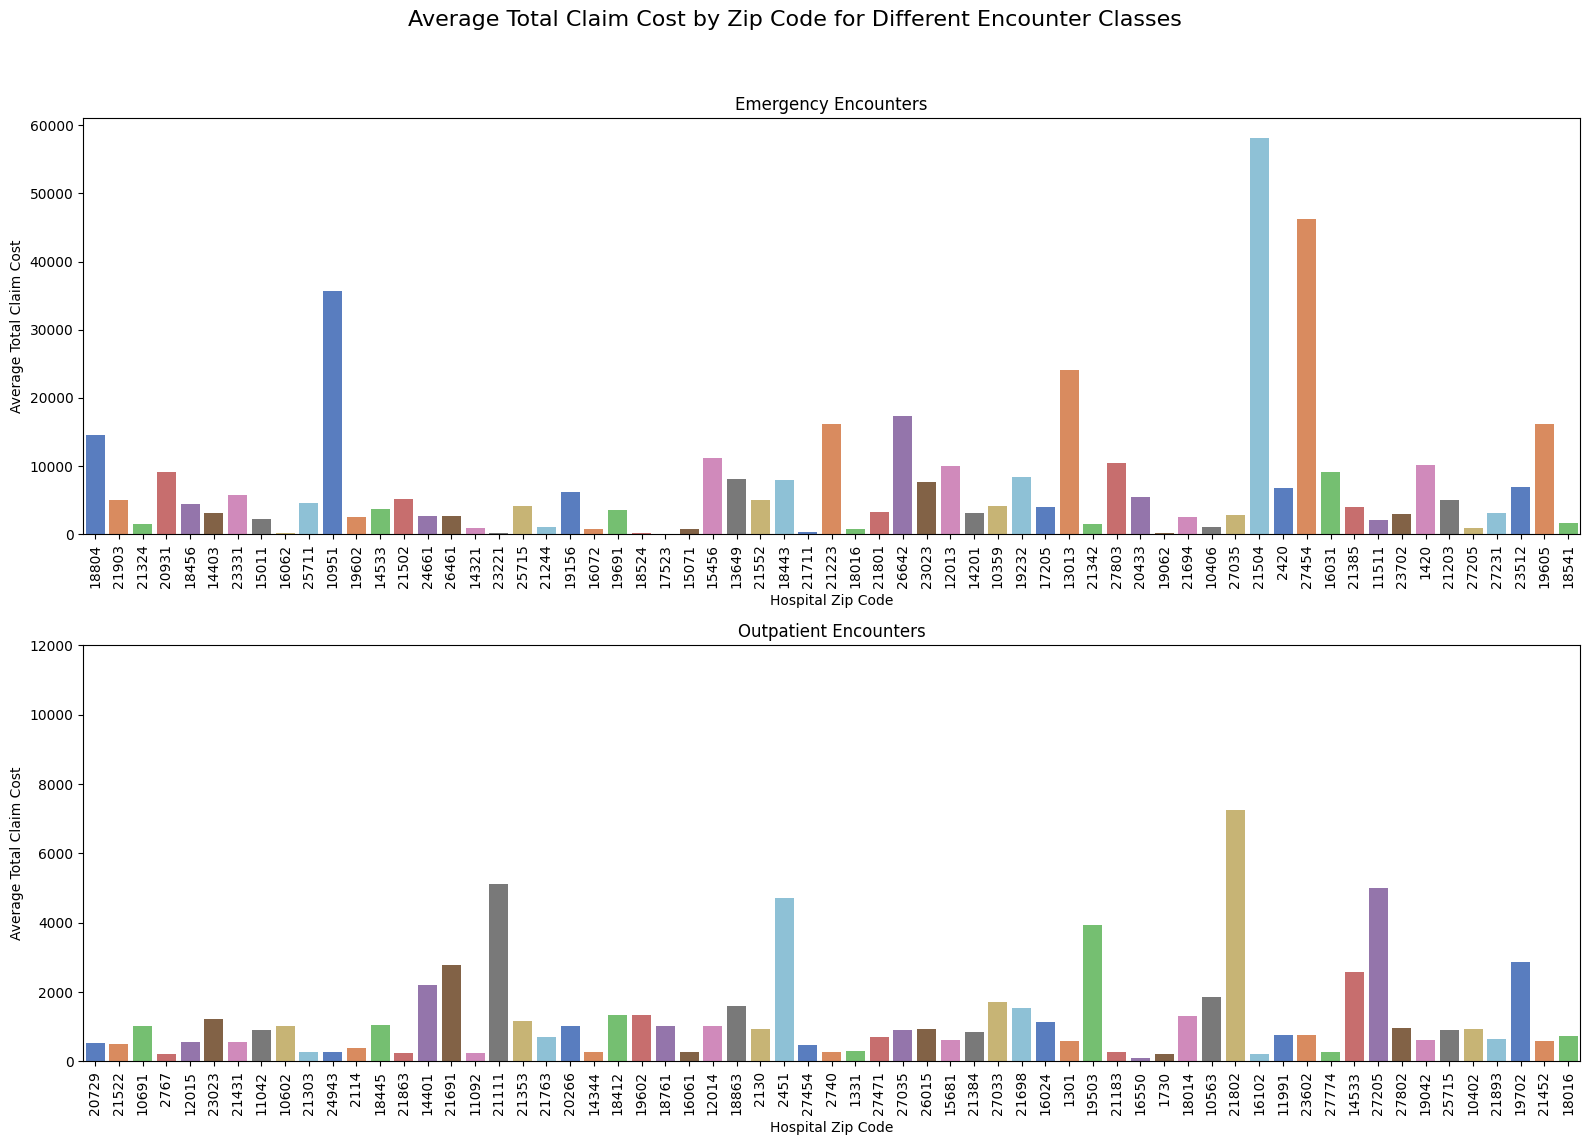

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert to pandas
zip_summary_pd = zip_summary.toPandas()

# Select 4 encounter classes (or change to your preferred ones)
classes = ["emergency", "outpatient"]
filtered = zip_summary_pd[zip_summary_pd["ENCOUNTERCLASS"].isin(classes)]

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

for ax, encounter_class in zip(axes.flatten(), classes):
    class_data = filtered[filtered["ENCOUNTERCLASS"] == encounter_class]
    sns.barplot(
        data=class_data,
        x="organization_zip",
        y="avg_total_claim",
        ax=ax,
        palette="muted"
    )
    ax.set_title(f"{encounter_class.title()} Encounters")
    ax.set_xlabel("Hospital Zip Code")
    ax.set_ylabel("Average Total Claim Cost")
    ax.tick_params(axis='x', rotation=90)

    # Rescale y-axis for outpatient only
    if encounter_class == "outpatient":
        ax.set_ylim(0, 12000)

plt.suptitle("Average Total Claim Cost by Zip Code for Different Encounter Classes", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

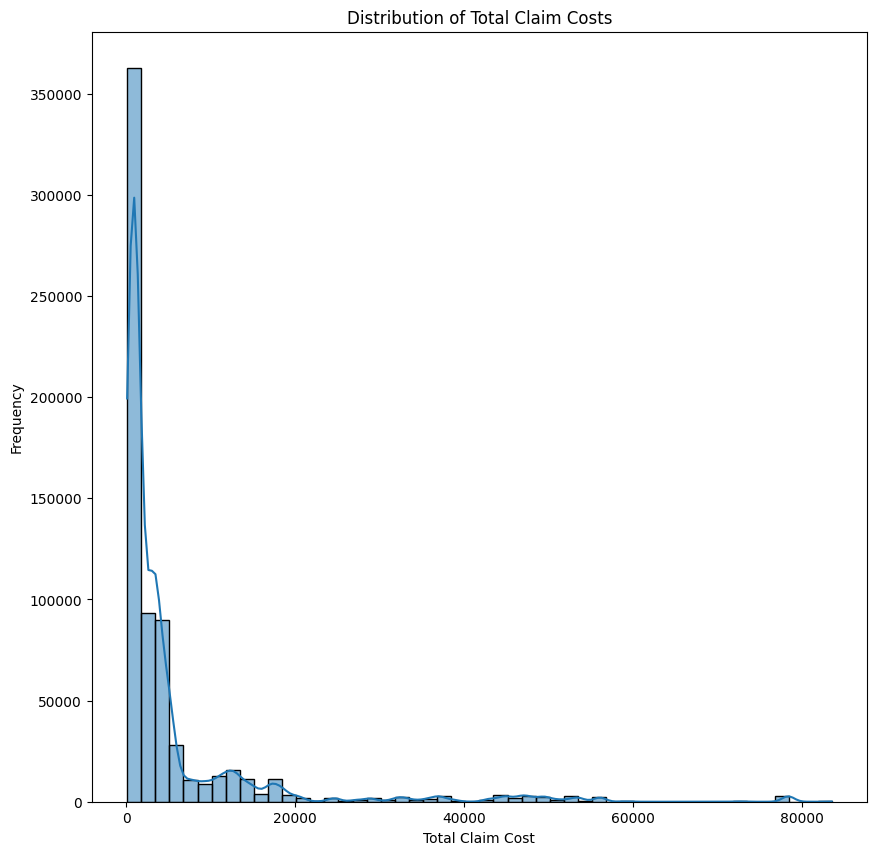

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sample from Spark (optional if payer_summary_pd already exists)
costs_pd = encounters.select("TOTAL_CLAIM_COST").dropna().toPandas()
costs_pd["TOTAL_CLAIM_COST"] = costs_pd["TOTAL_CLAIM_COST"].astype(float)

# Histogram with KDE
plt.figure(figsize=(10, 10))
sns.histplot(costs_pd["TOTAL_CLAIM_COST"], bins=50, kde=True)
plt.title("Distribution of Total Claim Costs")
plt.xlabel("Total Claim Cost")
plt.ylabel("Frequency")
plt.show()

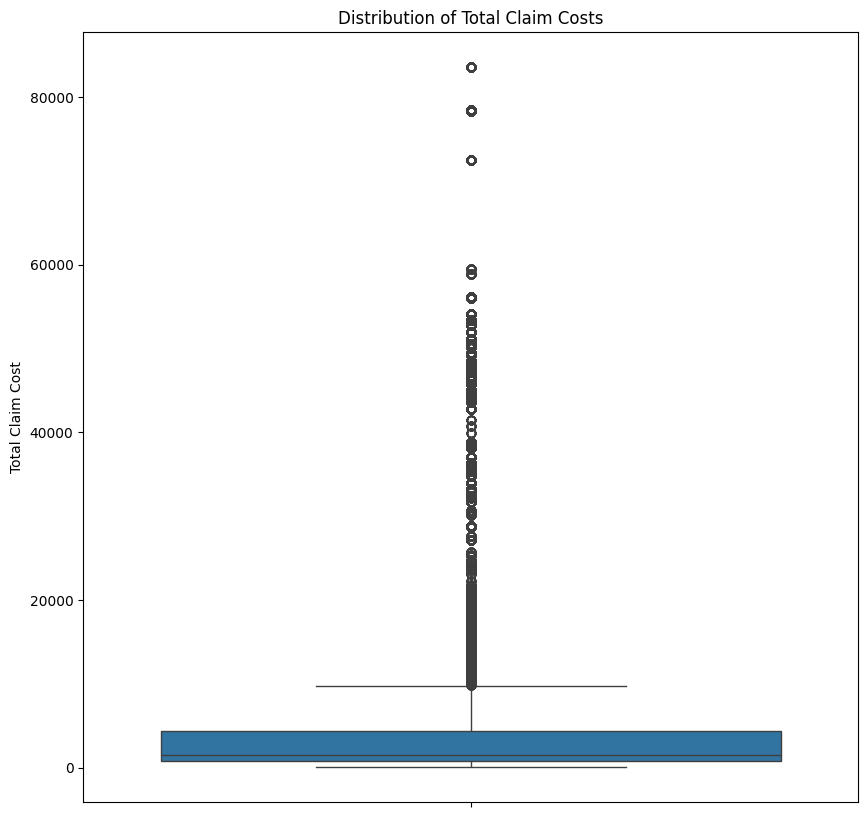

In [43]:
plt.figure(figsize=(10, 10))
sns.boxplot(y=costs_pd["TOTAL_CLAIM_COST"])
plt.title("Distribution of Total Claim Costs")
plt.ylabel("Total Claim Cost")
plt.show()